In [1]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Clean the input directory structure.
! rm -rf cmp23 icdar preprocessed features
! mkdir -p {cmp23,icdar}/{fe,}male

# Self explanatory.
! cp ../input/cmp23-handwritten-males-vs-females/Males/Males/* cmp23/male
! cp ../input/cmp23-handwritten-males-vs-females/Females/Females/* cmp23/female

# Copy the zip files and the train answers.
! cp ../input/icdar2013-gender-prediction-from-handwriting/{[0-9]*_[0-9]*.zip,train_answers.csv} icdar
# Unzip in the working directory.
! for z in $(ls icdar/*.zip); do unzip $z -d icdar >/dev/null; done
# Couldn't break this line into many. The notebook treats each line as a bash shell of its own.
! cd icdar; tail +2 train_answers.csv | while read -d, id && read gender; do id=$(printf "%04d" $id); [[ ${gender:0:1} = 1 ]] && gender=male || gender=female; mv "$id"_{3,4}.jpg $gender; done
# Delete unwanted files.
! rm icdar/{*.zip,*.jpg,train_answers.csv}
# Rename all the dataset files to simple names.
! function rename { for path in "$@"; do cd $path; c=1; for file in $(ls); do mv $file $c.jpg; let c=c+1; done; cd - >/dev/null; done; }; rename {cmp23,icdar}/{fe,}male

# Check the directory tree.
! tree --filelimit 100

.
├── __notebook__.ipynb
├── cmp23
│   ├── female [131 entries exceeds filelimit, not opening dir]
│   └── male [232 entries exceeds filelimit, not opening dir]
└── icdar
    ├── female [286 entries exceeds filelimit, not opening dir]
    └── male [278 entries exceeds filelimit, not opening dir]

6 directories, 1 file
CPU times: user 1.42 s, sys: 266 ms, total: 1.69 s
Wall time: 1min 23s


In [2]:
# Imports.
import os
import glob
import cv2
import functools
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

In [3]:
# Helper functions.
def cmp(gender: str, id: int):
    return 'cmp23/' + gender + '/' + str(id) + '.jpg'

def icd(gender: str, id: int):
    return 'icdar/' + gender + '/' + str(id) + '.jpg'

def is_cmp(path: str):
    return 'cmp23' in path

def dataset(path: str):
    return 'cmp23' if is_cmp(path) else 'icdar'

def is_male(path: str):
    return 'female' not in path

def gender(path: str):
    return 1 if is_male(path) else 0

def pre(version: str):
    return lambda image_path: f'preprocessed/{version}/{image_path}'

def feat(feature: str, dataset: str):
    return f'features/{feature}/{dataset}.ft'

def preview(images: list):
    fig = plt.figure(figsize=(20, 20))
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(image, cmap='gray')
    plt.show()

def imread_bw(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.where(image > 255 / 2, 1, 0)

def norm(features):
    features = normalize(features, axis=0)
    # Ceil all the fractions (representing male class) back to one.
    features[features[:, -1] > 0, -1] = 1
    return features

def ojalat_lbp(image, n_points=16, radius=2):
    lbp = local_binary_pattern(image, n_points, radius, method='nri_uniform')
    # [n * (n - 1) + 2] for uniform bp and [1] more bin for non uniform bp.
    n_bins = n_points * (n_points - 1) + 2 + 1
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(n_bins + 1))
    return hist

In [4]:
# Constants.
CMP_IMAGES = glob.glob(cmp('*', '*'))
ICD_IMAGES = glob.glob(icd('*', '*'))
ALL_IMAGES = CMP_IMAGES + ICD_IMAGES

TST_IMAGES = [
    cmp('female', 9),
    icd('male', 67),
    cmp('male', 89),
    icd('female', 3),
    icd('male', 12),
    cmp('female', 4),
] # Some images' paths used oberservation.

# Remove corrupt images from our image lists, like F87.jpg.
for image_path in ALL_IMAGES:
    if cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) is None:
        ALL_IMAGES.remove(image_path)
        TST_IMAGES.remove(image_path)

In [5]:
# More constansts.
CMP = 'cmp23'
ICD = 'icdar'

PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE = (9, 9)
PREPROCESSING_DILATION_ITERATIONS = 8
PREPROCESSING_DILATION_SIZE = (15, 20) # We need more dilation into the vertical axis.
PREPROCESSING_THRESH_BLOCK_SIZE = 101 # 101 is quick enough, yet robust.
PREPROCESSING_THRESH_C = 30 # Note that we need a big C subtractor when we use a big block size.
X_CUT_PERCENT = 0.1 # Don't cut too much since some people write to edge of the paper.
Y_CUT_PERCENT = 0.5 # 0.5% on both sides is enough.

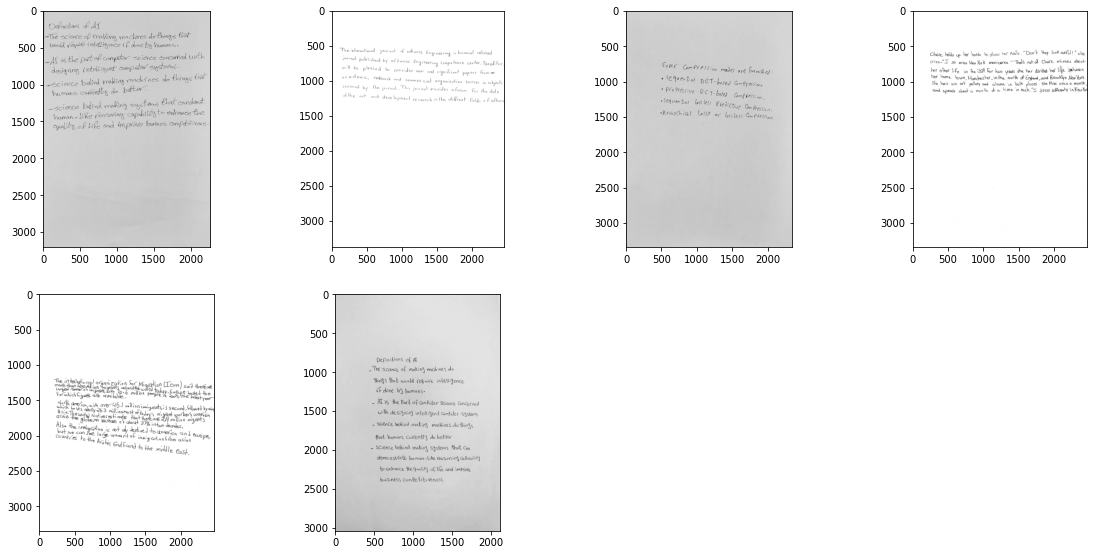

In [6]:
# Preview the test images before preprocessing them.
preview(TST_IMAGES)

In [7]:
# Make a directory for the preprocessed versions of the datatset.
! mkdir -p preprocessed/{bw,gray}/{cmp23,icdar}/{fe,}male

In [8]:
%%time
# Preprocess the images and write them to the disk.
for image_path in ALL_IMAGES:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Cut some percentage of the images' edges. They are usually noisy.
    height, width = image.shape
    if X_CUT_PERCENT:
        start_x, end_x = int(width / (100/X_CUT_PERCENT)), width - int(width / (100/X_CUT_PERCENT))
        image = image[:, start_x:end_x]
    if Y_CUT_PERCENT:
        start_y, end_y = int(height / (100/Y_CUT_PERCENT)), height - int(height / (100/Y_CUT_PERCENT))
        image = image[start_y:end_y, :]
    # Blur the image to decrease sharpness. Good for thresholding.
    img = cv2.GaussianBlur(image, PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE, 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    # Dilate the image to create a contour out of the handwritten text.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, PREPROCESSING_DILATION_SIZE)
    img = cv2.dilate(img, kernel, iterations=PREPROCESSING_DILATION_ITERATIONS)
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    # Get the biggest contour that contains the text.
    biggest_contour = functools.reduce(lambda c1, c2: c1 if cv2.contourArea(c1) > cv2.contourArea(c2) else c2,
                                       contours)
    # Get the original image in black and white. Note that this version is not blured.
    bw = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                               PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    bw = cv2.threshold(bw, 255 / 2, 255, cv2.THRESH_BINARY)[1]
    # Crop only the text part.
    x, y, w, h = cv2.boundingRect(biggest_contour)
    image = image[y:y + h, x:x + w] # This is a gray version
    bw = bw[y:y + h, x:x + w] # This is a BW version
    # Write the preprocessed images to the disk.
    cv2.imwrite(pre('gray')(image_path), image)
    cv2.imwrite(pre('bw')(image_path), bw)

CPU times: user 12min 4s, sys: 13.8 s, total: 12min 18s
Wall time: 11min 40s


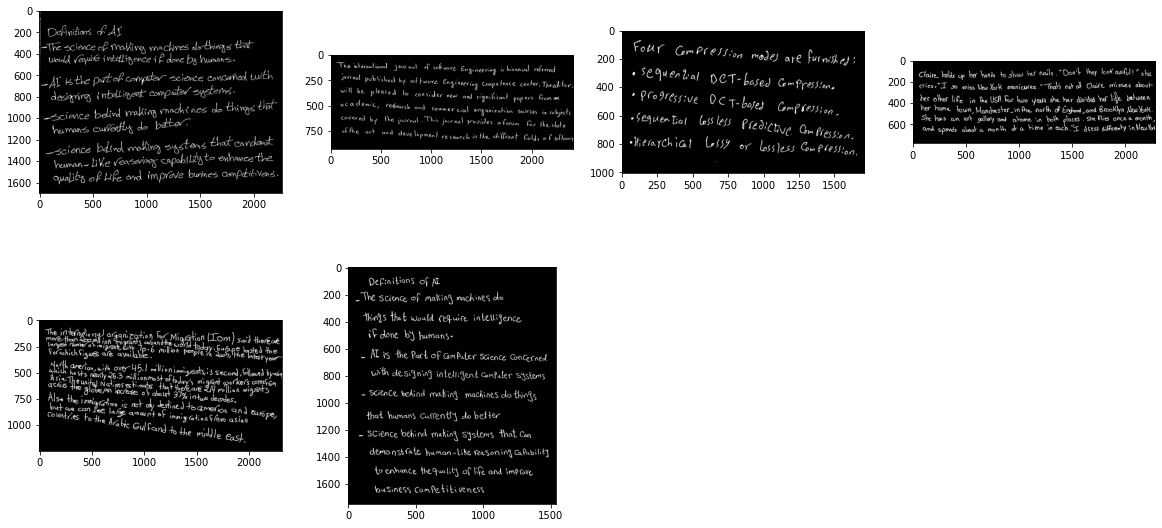

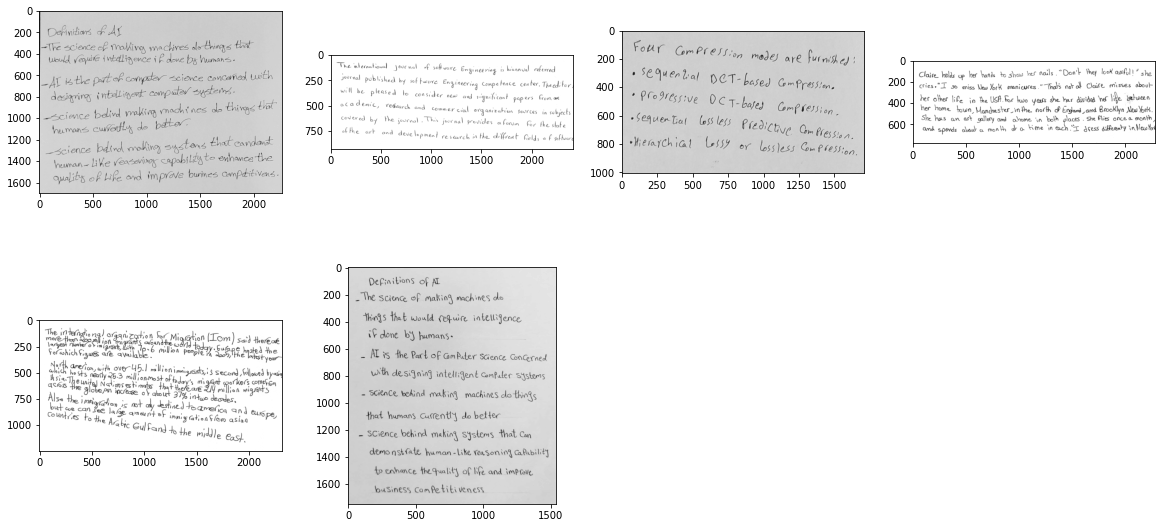

In [9]:
# Preview the test images after preprocessing.
bw_test_images = map(pre('bw'), TST_IMAGES)
gray_test_images = map(pre('gray'), TST_IMAGES)

preview(bw_test_images)
preview(gray_test_images)

In [10]:
def svm_test(features, times=100, test_size=0.2, **kwargs):
    tr_ac, ts_ac, mal, fem = 0, 0, 0, 0
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(features[:,:-1], features[:,-1], test_size=test_size)
        clf = svm.SVC(**kwargs)
        clf.fit(X_train, y_train)
        tr_ac += clf.score(X_train, y_train)
        ts_ac += clf.score(X_test, y_test)
        mal += np.sum(clf.predict(features[:,:-1]) == 1) / len(features[:,:-1])
        fem += np.sum(clf.predict(features[:,:-1]) == 0) / len(features[:,:-1])
    ret = ts_ac * 100 / times, tr_ac * 100 / times, mal * 100 / times, fem * 100 / times
    print('male_predict% = {}\nfemale_predict% = {}'.format(*ret[2:]))
    return ret[:2]

def ann_test(features):
    pass

def plt_test(features):
    males = features[features[:,-1] == 1]
    females = features[features[:,-1] == 0]
    for f1 in range(0, len(males[0,:-1])):
        print(f1)
        plt.plot(males[:, f1], males[:, -1], 'bo')
        plt.plot(females[:, f1], females[:, -1], 'rx')
        plt.show()

In [11]:
# Make a directory for each and every feature we have.
! mkdir -p features/{lbp,glcm,gabor,ar_coeff,hog,chain_codes,chain_code_pairs,segment_slopes,dist_curv,cold,hinge}

In [12]:
%%time
# GLCM features.
angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
distances = [1]
props = ['contrast', 'homogeneity', 'energy', 'correlation', 'entropy']

cmp_features = []
icd_features = []

for image_path in map(pre('bw'), ALL_IMAGES):
    image = imread_bw(image_path)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=2, symmetric=False, normed=True)
    features = []
    for prop in props:
        if prop == 'entropy':
            # Since graycoprops doesn't support calculating entropy.
            features.append([-np.sum(glcm[:, :, d, a] * np.log(glcm[:, :, d, a])) for d in range(len(distances)) for a in range(len(angles))])
        else:
            features.append(graycoprops(glcm, prop).ravel())
    features.append(gender(image_path))
    features = np.hstack(features)
    if is_cmp(image_path):
        cmp_features.append(features)
    else:
        icd_features.append(features)

# Normalize the features and save them.
np.savetxt(feat('glcm', CMP), norm(cmp_features))
np.savetxt(feat('glcm', ICD), norm(icd_features))

CPU times: user 52.1 s, sys: 2.08 s, total: 54.2 s
Wall time: 54.3 s


In [13]:
cmp_features = np.loadtxt(feat('glcm', CMP))
icd_features = np.loadtxt(feat('glcm', ICD))
features = cmp_features
svm_test(features, C=10, kernel='rbf', test_size=0.2, times=1000)

male_predict% = 76.1338842975206
female_predict% = 23.86611570247933


(67.63013698630122, 76.2641379310335)

In [14]:
%%time
# LBP features.
cmp_features = []
icd_features = []

for image_path in map(pre('bw'), ALL_IMAGES):
    image = imread_bw(image_path)
    features = np.append(ojalat_lbp(image), gender(image_path))
    if is_cmp(image_path):
        cmp_features.append(features)
    else:
        icd_features.append(features)

# Normalize the features and save them.
np.savetxt(feat('lbp', CMP), norm(cmp_features))
np.savetxt(feat('lbp', ICD), norm(icd_features))

CPU times: user 16min 15s, sys: 15.2 s, total: 16min 30s
Wall time: 16min 32s


In [15]:
cmp_features = np.loadtxt(feat('lbp', CMP))
icd_features = np.loadtxt(feat('lbp', ICD))
features = icd_features
svm_test(features, C=10, kernel='rbf', test_size=0.2, times=100)

male_predict% = 46.68794326241135
female_predict% = 53.31205673758866


(69.88495575221238, 86.37472283813746)

In [16]:
%%time
import random

def ojalat_lbp(image, n_points=16, radius=2):
    lbp = local_binary_pattern(image, n_points, radius, method='nri_uniform')
    # [n * (n - 1) + 2] for uniform bp and [1] more bin for non uniform bp.
    n_bins = n_points * (n_points - 1) + 2 + 1
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(n_bins + 1))
    return hist

# LBP features.
features = []
random.shuffle(CMP_IMAGES)

for image_path in map(pre('bw'), CMP_IMAGES):
    image = imread_bw(image_path)
    if image is None: continue
    features.append(np.append(ojalat_lbp(image), gender(image_path)))
    
print(len(features), len(features[0]))
features = norm(features)
print(features)

svm_test(features, C=10, kernel='rbf', test_size=0.2, times=100)

363 244
[[1.54489035e-02 6.60244020e-03 0.00000000e+00 ... 4.20109025e-02
  3.82287902e-02 1.00000000e+00]
 [2.72194966e-02 2.97109809e-02 0.00000000e+00 ... 3.64440472e-02
  4.38222636e-02 1.00000000e+00]
 [3.67831035e-04 1.65061005e-03 0.00000000e+00 ... 3.15824852e-02
  2.54858601e-02 1.00000000e+00]
 ...
 [4.41397242e-03 3.30122010e-03 0.00000000e+00 ... 2.48373779e-02
  1.41948981e-02 1.00000000e+00]
 [4.78180346e-03 4.95183015e-03 0.00000000e+00 ... 3.26038936e-02
  1.65808807e-02 1.00000000e+00]
 [1.22855566e-01 9.73859930e-02 0.00000000e+00 ... 6.09049606e-02
  5.19948907e-02 1.00000000e+00]]
male_predict% = 67.73002754820936
female_predict% = 32.26997245179063
CPU times: user 5min 54s, sys: 4.75 s, total: 5min 59s
Wall time: 5min 59s


(73.39726027397256, 90.60689655172406)